### Introduction

This Jupyter notebook uses the [Titanic dataset from Kaggle](https://www.kaggle.com/c/titanic) for the prediction of survival rates among passengers on the Titanic.

> [RMS Titanic](https://en.wikipedia.org/wiki/RMS_Titanic) was a British passenger liner that sank in the North Atlantic Ocean in the early morning of 15 April 1912, after colliding with an iceberg during her maiden voyage from Southampton to New York City. Of the 2,224 passengers and crew aboard, more than 1,500 died in the sinking, making it one of the deadliest commercial peacetime maritime disasters in modern history. The largest ship afloat at the time it entered service, the RMS Titanic was the second of three Olympic class ocean liners operated by the White Star Line, and was built by the Harland and Wolff shipyard in Belfast. Thomas Andrews, her architect, died in the disaster.

The main goals of this analysis are a descriptive analysis of the data, a sophisticated feature engineering approach, and a comparison of established prediction models. In addition to that, the whole analysis should be presented in the best possible way, so that the notebook serves as a best practice example.

In [1]:
%matplotlib inline

import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from time import time
from pathlib import Path
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

sns.set_style('whitegrid')
np.random.seed(123)

C:\Users\tobia\AppData\Local\conda\conda\envs\titanic\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train = pd.read_csv(Path('data', 'train.csv'))
test = pd.read_csv(Path('data', 'test.csv'))

train.Embarked = train.Embarked.map({
    'S': 'Southampton',
    'C': 'Cherbourg',
    'Q': 'Queenstown'
})
train.Sex = train.Sex.map({'female': 'Female', 'male': 'Male'})
test.Embarked = test.Embarked.map({
    'S': 'Southampton',
    'C': 'Cherbourg',
    'Q': 'Queenstown'
})
test.Sex = test.Sex.map({'female': 'Female', 'male': 'Male'})

### Descriptive Analysis

For exploration the whole dataset is used. It consists of 1309 observations and 12 variables. The variables are:

| *Variable* | *Description* | *dtype* | *non-missing train* | *non-missing test* |
| :--- | :--- | :--- | :--- | :--- |
| Age | Age of passenger | float64 | 714 | 332 |
| Cabin | Cabin of passenger | object | 204 | 91 |
| Embarked  | Capital letter indicating the port of embarkation | object | 889 | 417 |
| Fare | Price of ticket | float64 | 891 | 418 |
| Name | Name of passenger | object | 891 | 418 |
| Parch | Number of parents & children aboard | int64 | 891 | 418 |
| PassengerId | ID of passenger | int64 | 891 | 418 |
| Pclass | Class of passenger | int64 | 891 | 418 |
| Sex | Sex of passenger | object | 891 | 418 |
| SibSp | Number of siblings & spouses aboard | int64 | 891 | 418 |
| Survived | Survived (1) or deceased (0) | int64 | 891 | 418 |
| Ticket | Ticket number | object| 891 | 418 |

#### PassengerId, Ticket, Cabin

These variables are not important for the analysis.

#### Passenger Class

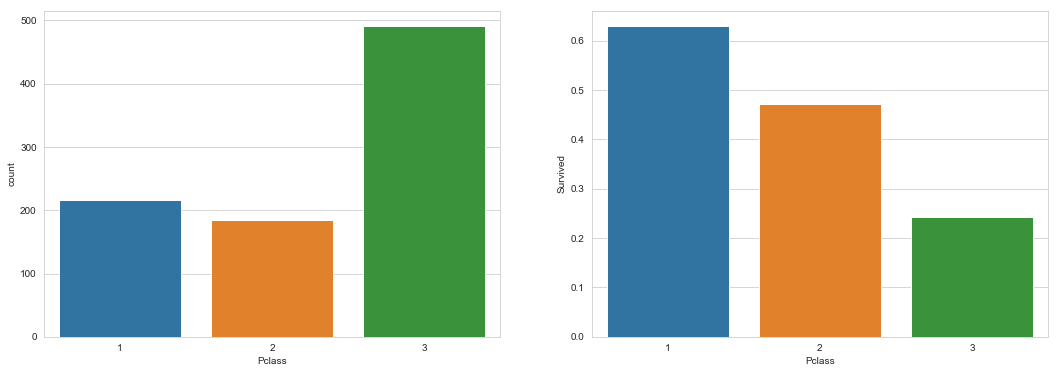

In [3]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 6))
sns.countplot(x='Pclass', data=train, ax=axis1)
sns.barplot(x='Pclass', y='Survived', data=train, ax=axis2, ci=None)
plt.show()

#### Sex

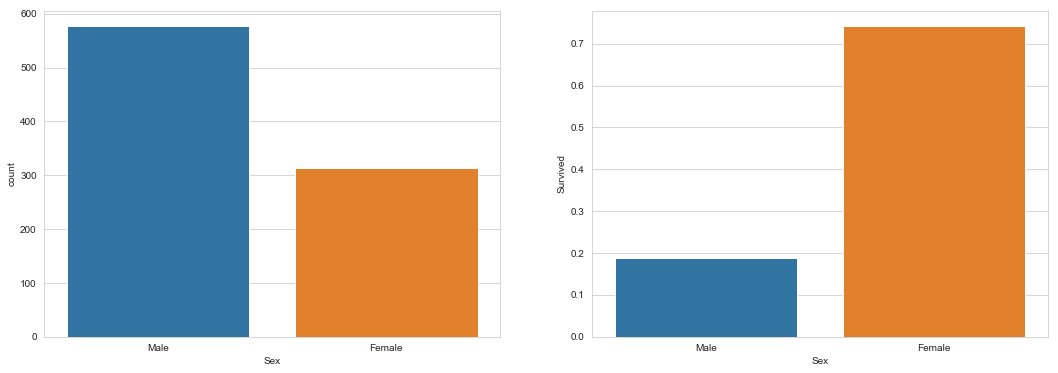

In [4]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 6))
sns.countplot(x='Sex', data=train, ax=axis1)
sns.barplot(x='Sex', y='Survived', data=train, ax=axis2, ci=None)
plt.show()

#### Age

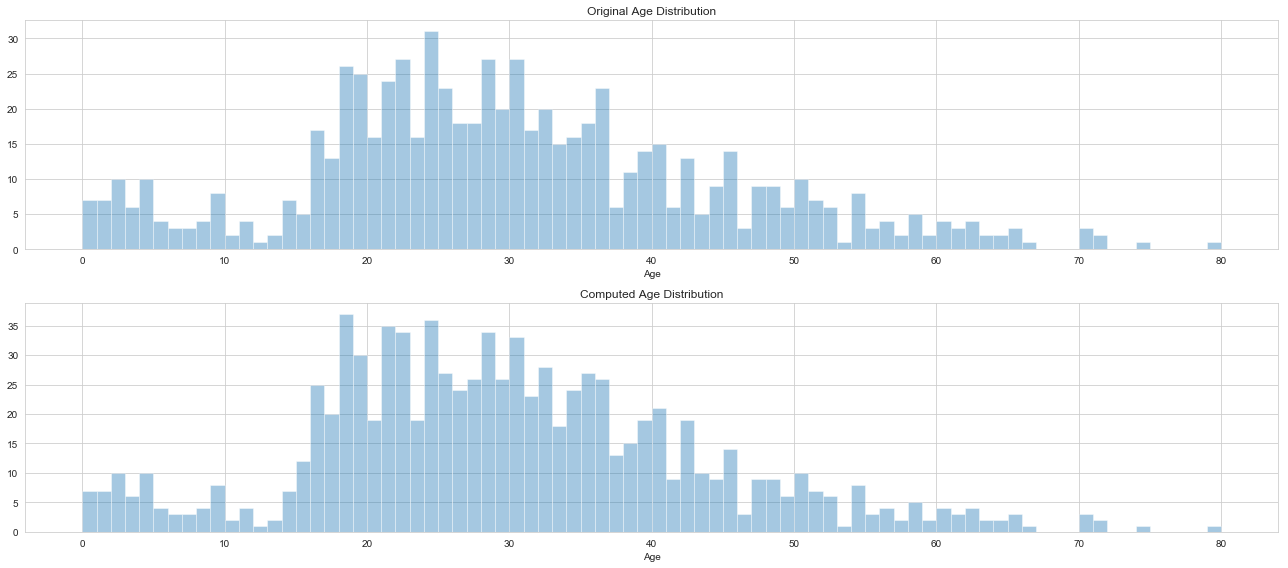

In [5]:
# Create a dummy for missing age values for later computation
train['missing_age'] = train.Age.isnull()
test['missing_age'] = test.Age.isnull()

# Missing computation (could be more sophisticated, since it is only
# uniformly distributed)
train_age_mean = train.Age.mean()
train_age_std = train.Age.std()
train_age_nan_count = train.Age.isnull().sum()

test_age_mean = test.Age.mean()
test_age_std = test.Age.std()
test_age_nan_count = test.Age.isnull().sum()

train_age_rand = np.random.randint(
    train_age_mean - train_age_std,
    train_age_mean + train_age_std,
    size=train_age_nan_count)
test_age_rand = np.random.randint(
    test_age_mean - test_age_std,
    test_age_mean + test_age_std,
    size=test_age_nan_count)

# Original distribution
orig_train_age_int = train.Age.dropna().astype(int)
orig_test_age_int = test.Age.dropna().astype(int)

# Computed age distribution
train.loc[train.Age.isnull(), 'Age'] = train_age_rand
comp_train_age_int = train.Age.astype(int)
test.loc[test.Age.isnull(), 'Age'] = test_age_rand
comp_test_age_int = test.Age.astype(int)

fig, (axis1, axis2) = plt.subplots(2, 1, figsize=(18, 8))
axis1.set_title('Original Age Distribution')
sns.distplot(
    orig_train_age_int, ax=axis1, kde=False, bins=np.arange(0, 80.5, 1))
axis2.set_title('Computed Age Distribution')
sns.distplot(
    comp_train_age_int, ax=axis2, kde=False, bins=np.arange(0, 80.5, 1))
plt.tight_layout()
plt.show()

# Convert Age from float to int, because of simplicity
train.Age = train.Age.astype(int)
test.Age = test.Age.astype(int)

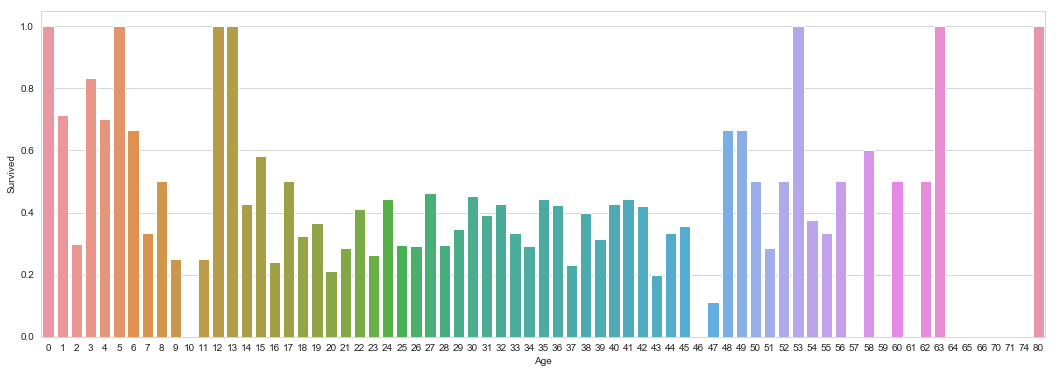

In [6]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot('Age', 'Survived', data=train, ax=ax, ci=False)
plt.show()

#### Fare

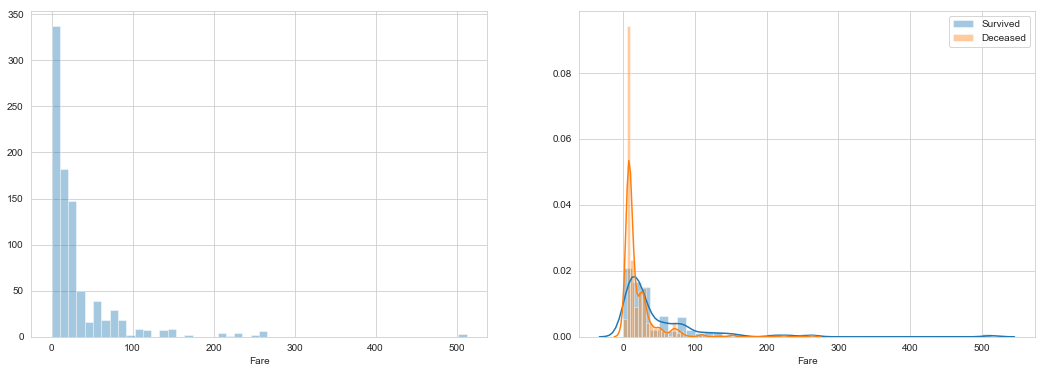

In [7]:
# Could be better, think about a more appropriate solution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.distplot(train.Fare, kde=False, ax=ax1)
sns.distplot(train[train.Survived == 1]['Fare'], kde=True, ax=ax2)
sns.distplot(train[train.Survived == 0]['Fare'], kde=True, ax=ax2)
ax2.legend(['Survived', 'Deceased'])
plt.show()

### Missing Computation and Feature Engineering

#### Fare

We forgot to fix one missing value in fare in the test dataset. We will replace it by the median fare value for the specific passenger class.

In [8]:
test.Fare = test.Fare.fillna(test.loc[test.Pclass == 3, 'Fare'].median())

#### Cabin

Previously discarded, we will take a look at the cabin variable. The variable consists of a letter indicating the deck and a room number. The number is less important, but an indicator variable for the deck could reveal further information despite the fact that the cabin number is missing in 75% of the data. For further information look at [Wikipedia](https://en.wikipedia.org/wiki/RMS_Titanic#Dimensions_and_layout).

It seems impossible to predict deck membership.

In [9]:
train['Deck'] = train.Cabin.astype(str).str.extract(
    "(?P<letter>[A-Z])", expand=False)
train.loc[train.Deck.isnull(), 'Deck'] = 'Missing'
test['Deck'] = test.Cabin.astype(str).str.extract(
    "(?P<letter>[A-Z])", expand=False)
test.loc[test.Deck.isnull(), 'Deck'] = 'Missing'

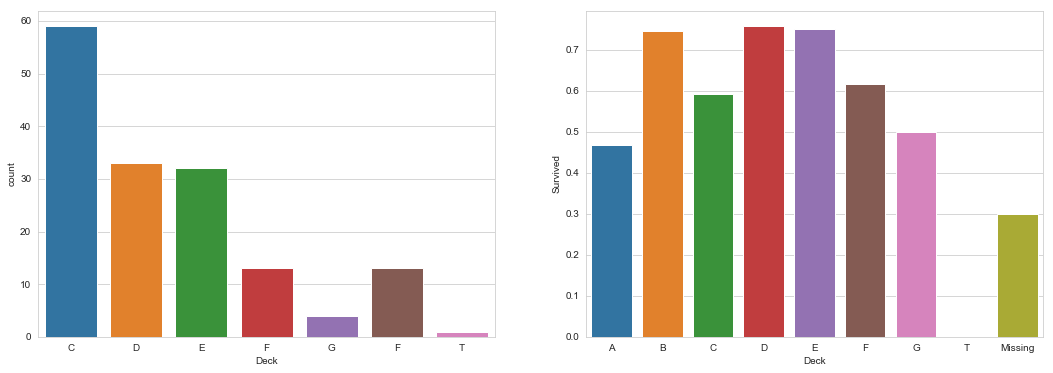

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.countplot(
    'Deck', data=train, ax=ax1, order=['C', 'D', 'E', 'F', 'G', 'F', 'T'])
sns.barplot(x='Deck', y='Survived', data=train, ax=ax2,
    order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Missing'], ci=False)
plt.show()

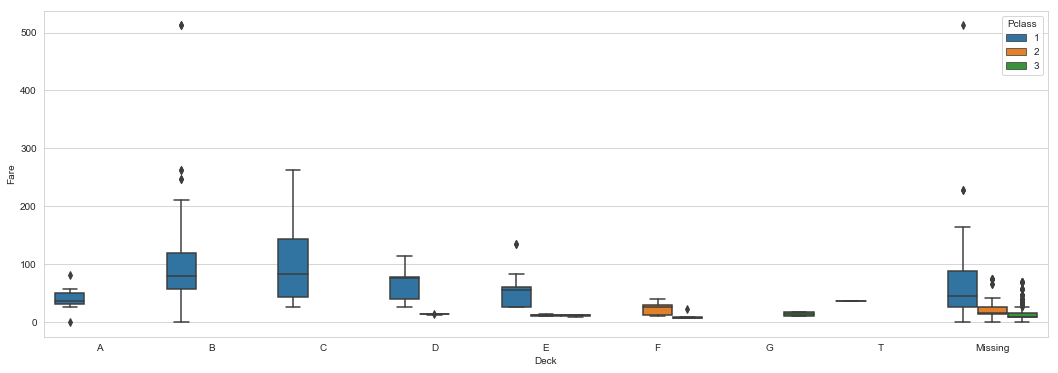

In [11]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.boxplot(x='Deck', y='Fare', hue='Pclass', data=train, ax=ax,
            order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'Missing'])
plt.show()

#### Embarked

There are two missing values in the training dataset. Let us have a look at the port of embarkation and the fare. The dotted horizontal line in the second graph shows the fare value of observations with missing port values. The fare values seem to overlap with Cherbourg.

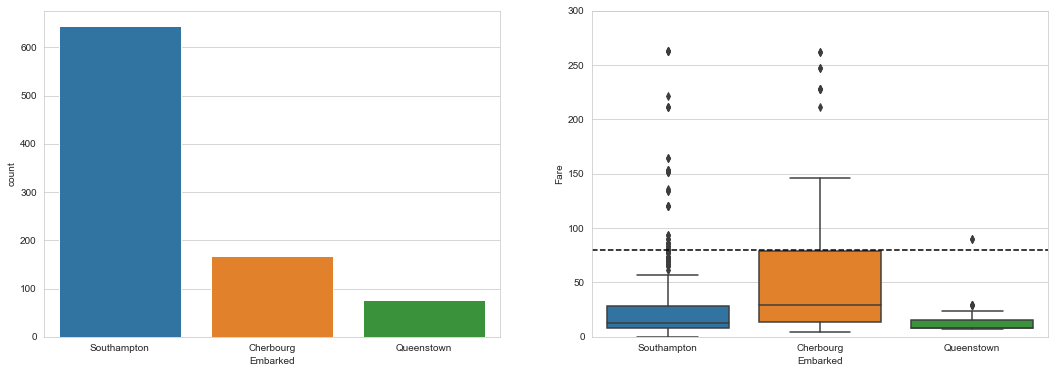

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.countplot('Embarked', data=train, ax=ax1)
# limit yaxis, because of outlier
sns.boxplot(x='Embarked', y='Fare', data=train, ax=ax2)
ax2.set_ylim([0, 300])
ax2.axhline(80, c='black', linestyle='--')
plt.show()

The boxplot does not show very clear whether the two passengers embarked in Southampton or Cherbourg. A fare of 80 seems to be on the edge of the box and therefore on the upper quartile. What you can also see is a concentration of passengers embarked in Southampton between a fare of 70 and 90.

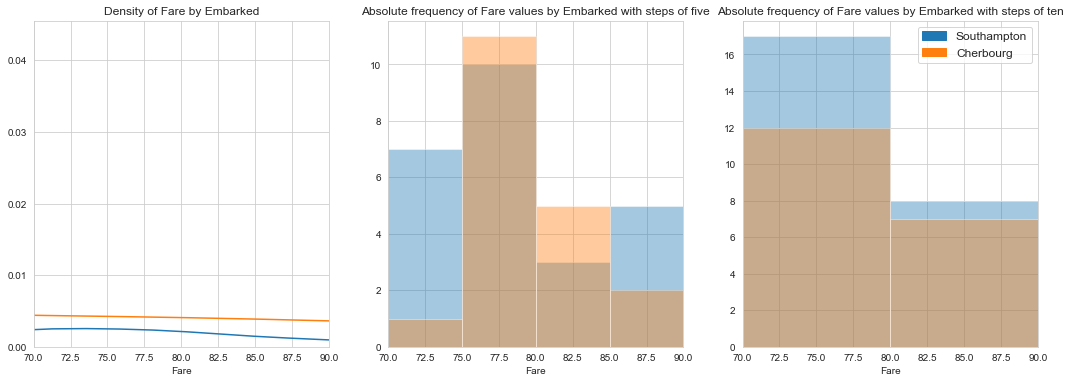

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

sns.distplot(train[train.Embarked == 'Southampton']['Fare'], ax=ax1,
             kde=True, hist=False)
sns.distplot(train[train.Embarked == 'Cherbourg']['Fare'], ax=ax1,
             kde=True, hist=False)
ax1.set_xlim([70, 90])
ax1.set_title('Density of Fare by Embarked')

sns.distplot(train[train.Embarked == 'Southampton']['Fare'], ax=ax2,
             kde=False, bins=np.arange(70, 91, 5))
sns.distplot(train[train.Embarked == 'Cherbourg']['Fare'], ax=ax2,
             kde=False, bins=np.arange(70, 91, 5))
ax2.set_xlim([70, 90])
ax2.set_title('Absolute frequency of Fare values by Embarked with steps of five')

sns.distplot(train[train.Embarked == 'Southampton']['Fare'], ax=ax3,
             kde=False, bins=np.arange(70, 91, 10))
sns.distplot(train[train.Embarked == 'Cherbourg']['Fare'], ax=ax3,
             kde=False, bins=np.arange(70, 91, 10))
ax3.set_xlim([70, 90])
ax3.set_title(
    'Absolute frequency of Fare values by Embarked with steps of ten')

south_patch = mpatches.Patch(color=sns.color_palette()[0],
                             label='Southampton')
cher_patch = mpatches.Patch(color=sns.color_palette()[1], 
                            label='Cherbourg')
plt.legend(handles=[south_patch, cher_patch], prop={'size': 12})
plt.show()

As you can see in graphic one, the density of for Cherbourg is slightly higher than for Southampton. But this is only in relation to all passengers from this port. Since passengers are not equally distributed among ports, we have to look at the absolute distribution. The histograms in graphic two and three show that the thresholds for similar observations is the critical assumption. Consider that passengers with fares from 75 to 85 are the correct comparison, you will favor Cherbourg over Southampton. But, you would have the opposite view if you choose fare values between 70 and 90.

Since normal data analysis seems to be ambiguous, I guide you to [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/), a site which offers more information about the passengers and their destiny, [deckplans](https://www.encyclopedia-titanica.org/titanic-deckplans/) and a lot more. The passenger list also includes biographies of passenger and among them the two. Mrs. Stone embarked with her maid Miss. Icard in Southampton [(Link)](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html).

In [14]:
# Set the embarked value of the couple to Southampton
train.loc[train.Embarked.isnull(), 'Embarked'] = 'Southampton'

#### Construct Title and Surname

Here we are going to construct a variable which includes the title and the surname of passengers. The title should also reveal insights into the socio-economic status of passengers if doctors or aristocrats are among these. This is probably already covered by face and passenger class, but nevermind. The second variable is especially important to find families among the passengers and see whether they have higher survival probabilities because of mutual assistance.

The titles are surprisingly not wildly different. There are only 18 different titles. There are Spanish and English aristocrates and also a Belgian or Dutch Jonkheer which is a title for a young aristocrat without a royal or noble rank. Some of titles are the same in different translations. In the dictionary below you can find the mapping to English expressions.

In a sample of 1309 observations there are 875 distinct surnames.

In [15]:
train['Title'] = train.Name.str.split(',', expand=True)[1].str.split(
    expand=True).get(0).str.strip('.')
train.loc[(train.Title == 'the'), 'Title'] = 'Countess'
test['Title'] = test.Name.str.split(',', expand=True)[1].str.split(
    expand=True).get(0).str.strip('.')
test.loc[(test.Title == 'the'), 'Title'] = 'Countess'

social_rank = {
    'Capt': 'Military', 'Col': 'Military', 'Major': 'Military',
    'Countess': 'Nobility', 'Jonkheer': 'Nobility',
    'Sir': 'Nobility',
    'Lady': 'Middle_Class', 'Don': 'Middle_Class',
    'Dr': 'Middle_Class', 'Master': 'Middle_Class',
    'Mlle': 'Unmarried_Woman', 'Ms': 'Unmarried_Woman',
    'Miss': 'Unmarried_Woman', 'Dona': 'Unmarried_Woman',
    'Mme': 'Married_Woman', 'Mrs': 'Married_Woman',
}
train.Title = train.Title.replace(social_rank)
test.Title = test.Title.replace(social_rank)

train['Surname'] = train.Name.str.split(',', expand=True).get(0)
test['Surname'] = test.Name.str.split(',', expand=True).get(0)

#### Age

Yes, again age. Before, we made very simple calculation to fill empty spaces. Now, we will try to compute age values by using a random forest regression.

In [16]:
# Prepare data for training
age_train = train.loc[train.missing_age == False].copy()
age_train['Pclass'] = age_train['Pclass'].astype(str)
age_test = train.loc[train.missing_age == True].copy()
age_test['Pclass'] = age_test['Pclass'].astype(str)
features = ['Sex', 'Fare', 'Embarked', 'Pclass', 'Parch', 'SibSp']
age_x = pd.get_dummies(age_train[features])
age_x_test = pd.get_dummies(age_test[features])
age_y = age_train['Age']

# Prepare data for test set
test_x = test.loc[test.missing_age == True, features]
test_x['Pclass'] = test_x['Pclass'].astype(str)
test_x = pd.get_dummies(test_x)

Let us have a look at feature importance.

Note that, in a previous version I also used `Survived` as a feature and it is the fith most important feature. But, obviously it is not included in the test set, so I will drop it for now and maybe revisit `Age` after we predicted the survival rates of passengers in the test set.

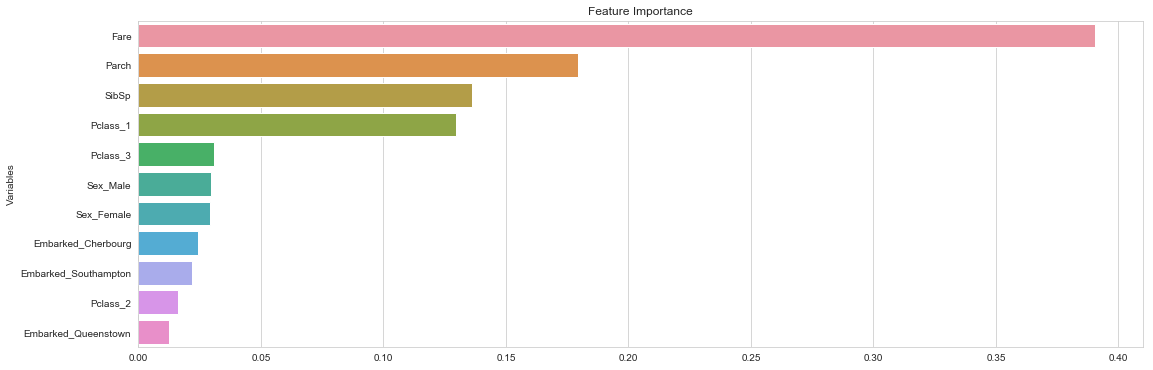

In [17]:
# Evaluate feature importance
clf = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
feat_imp = clf.fit(age_x, age_y).feature_importances_
age_feat_imp = pd.DataFrame(
    {'Variables': age_x.keys().values, 'Feature Importance': feat_imp}
).sort_values('Feature Importance', ascending=False)

fig, (axis1) = plt.subplots(1, 1, figsize=(18, 6))
sns.barplot(y='Variables', x='Feature Importance', data=age_feat_imp,
            ax=axis1, orient='h')
axis1.set_title('Feature Importance')
axis1.set_xlabel('')
plt.show()

This is a small plot to show the convergence speed of the ``RandomForestRegressor`` by the number of trees. It seems that basically 20 trees are sufficient. But since it is not computationally expensive, we will stick with 1000 trees to be on the safe side.

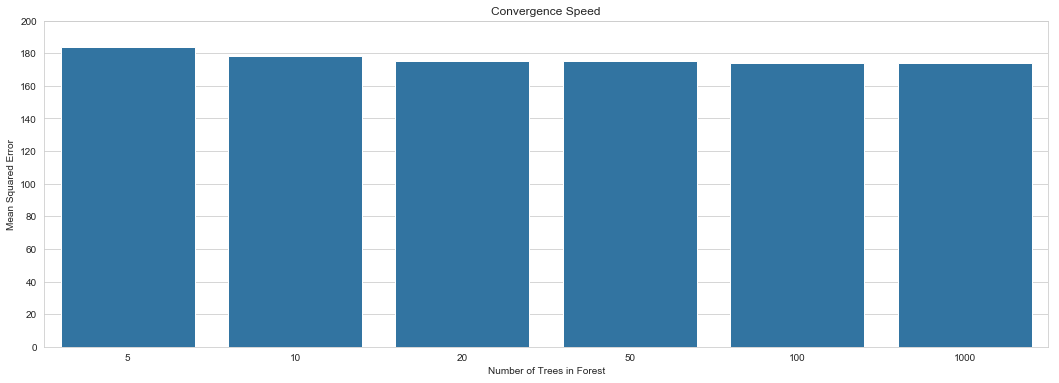

In [18]:
# Plot error convergence by number of estimators
trees = []
score = []
for i in [5, 10, 20, 50, 100, 1000]:
    clf = RandomForestRegressor(n_estimators=i, n_jobs=-1, max_features=0.5)
    scores = cross_val_score(
        clf, age_x, age_y, cv=5, scoring='neg_mean_squared_error')
    trees.append(i)
    score.append(-scores.mean())

fig, ax = plt.subplots(1, 1, figsize=(18, 6))
sns.barplot(x=trees, y=score, ax=ax, color='C0')
ax.set_yticks(np.arange(0, 201, 20))
ax.set_title('Convergence Speed')
ax.set_xlabel('Number of Trees in Forest')
ax.set_ylabel('Mean Squared Error')
plt.show()

In [19]:
# Predict the missing age values
clf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, max_features=0.5)
clf = clf.fit(age_x, age_y)
train.loc[train.missing_age == True, 'Age'] = clf.predict(age_x_test)

test.loc[test.missing_age == True, 'Age'] = clf.predict(test_x)

Let us look at the new distributions. The first comparison is to evaluate whether the overall distribution of age has significantly changed.

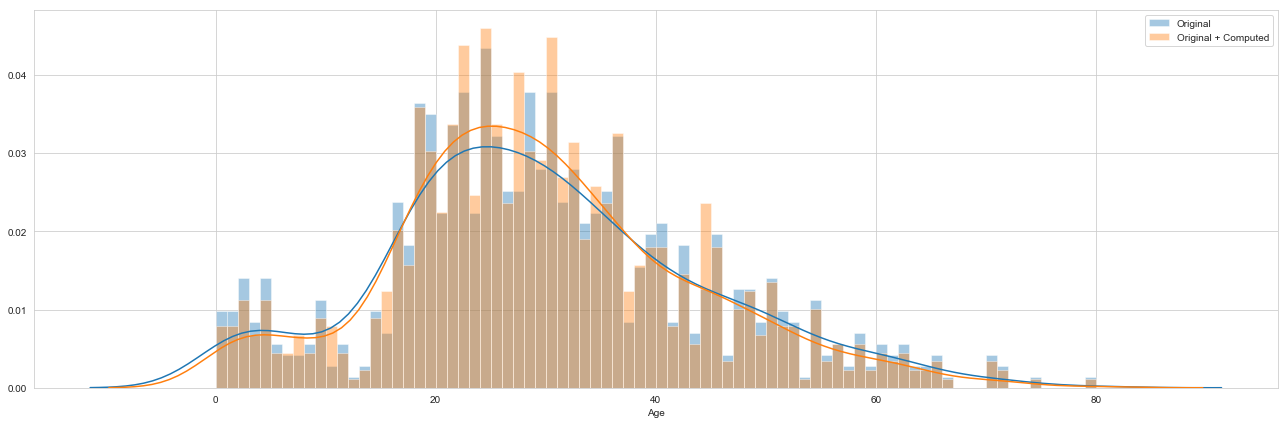

In [20]:
comp_train_age_int = train.Age.astype(int)

fig, ax = plt.subplots(figsize=(18, 6))
axis1.set_title('Original vs. Original + Computed Age Distribution')
sns.distplot(
    orig_train_age_int, ax=ax, kde=True, bins=np.arange(0, 80.5, 1))
sns.distplot(
    comp_train_age_int, ax=ax, kde=True, bins=np.arange(0, 80.5, 1))
ax.legend(['Original', 'Original + Computed'])
plt.tight_layout()
plt.show()

In the second comparison we can see the computed distribution tends to be more centered around 30. Of course, we cannot say whether this is false, since the groups could potentially differ. But more observations around the mean of the distribution will not make the data corrupt and the behaviour towards the tails is similar.

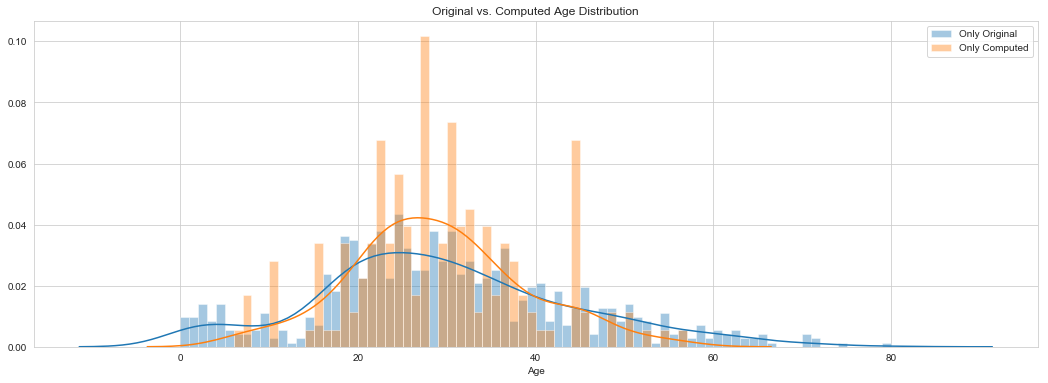

In [21]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.distplot(train.loc[train.missing_age == False, 'Age'],
             bins=np.arange(0, 80.5, 1), ax=ax)
sns.distplot(train.loc[train.missing_age == True, 'Age'],
             bins=np.arange(0, 80.5, 1), ax=ax)
ax.set_title('Original vs. Computed Age Distribution')
ax.legend(['Only Original', 'Only Computed'])
plt.show()

### Women and Children First!

In the next analysis we focus on a special code of conduct which states that women and children must be saved first in case of an emergency on the high sea. Here is an excerpt from Wikipedia:

> While the phrase first appeared in the 1860 novel Harrington: A Story of True Love, by William Douglas O'Connor, the first documented application of "women and children first" occurred during the 1852 evacuation of the Royal Navy troopship HMS Birkenhead. It is, however, most famously associated with the sinking of RMS Titanic in 1912. As a code of conduct, "women and children first" has no basis in maritime law. According to disaster evacuation expert Ed Galea, in modern-day evacuations people will usually "help the most vulnerable to leave the scene first. It's not necessarily women, but is likely to be the injured, elderly and young children." Furthermore, the results of a 2012 Uppsala University study said that the application of "women and children first" did not necessarily produce a survival advantage for women and children in practice.

At first, we have to find a definition for minors around that time. Since the captain and most of the crew were from English origin ([Wikipedia](https://en.wikipedia.org/wiki/Crew_of_the_RMS_Titanic)), we will follow the English definition of children. At the beginning of the new century childhood as nowadays did not exist, since children were treated as little adults. Instead of spending most of their time in school or playing with friends, children were allowed to work full time from the age of 12 and were minors until 14 ([20thcenturylondon](http://www.20thcenturylondon.org.uk/children)). For that reason, we will choose 14 as our cutoff.

In [22]:
train['Minor'] = train.Age <= 14
train.Minor = train.Minor.replace({0: 'Minor', 1: 'Adult'})

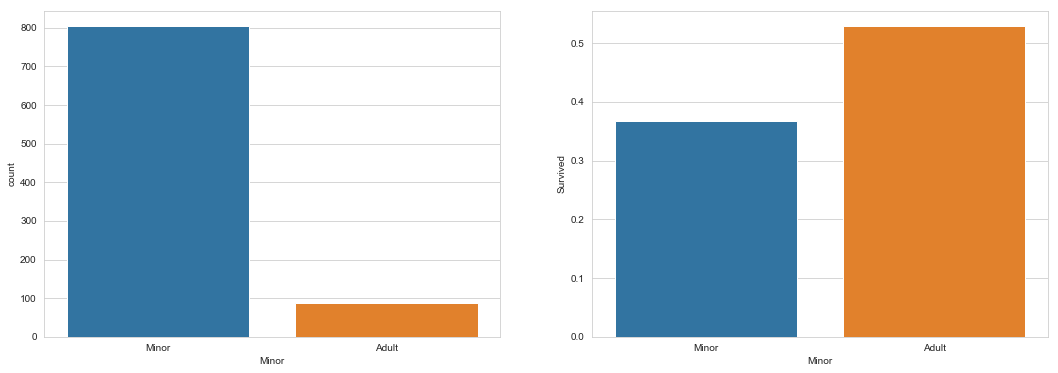

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.countplot('Minor', data=train, ax=ax1)
sns.barplot(x='Minor', y='Survived', data=train, ax=ax2, ci=False)
plt.show()

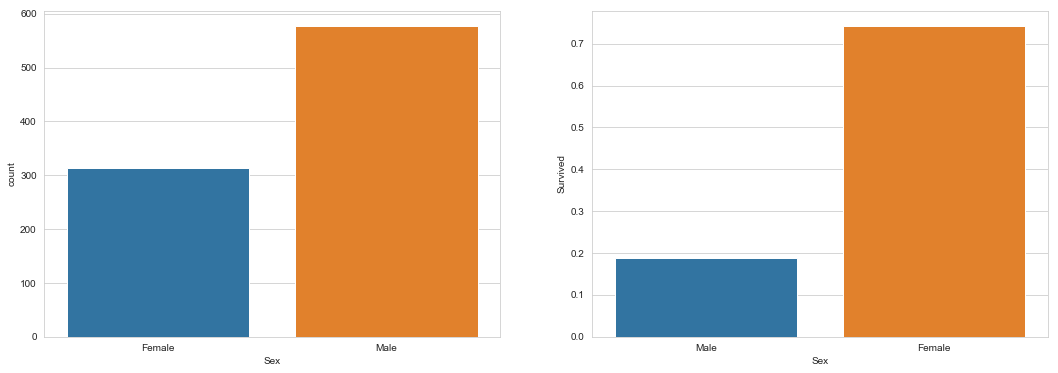

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.countplot('Sex', data=train, ax=ax1, order=['Female', 'Male'])
sns.barplot(x='Sex', y='Survived', data=train, ax=ax2, ci=False)
plt.show()

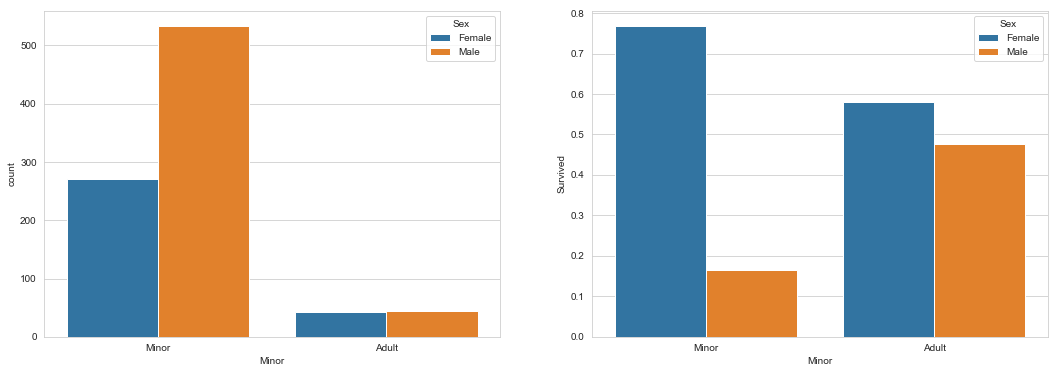

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.countplot('Minor', hue='Sex', data=train, ax=ax1,
              hue_order=['Female', 'Male'])
sns.barplot(x='Minor', y='Survived', hue='Sex', data=train, ax=ax2,
            hue_order=['Female', 'Male'], ci=False)
plt.show()

### A shared destiny? Families on board of the Titanic

After we extracted a surname, we can look for further details about families. First, we are creating a variable for the size of the family and we will look at a simple comparison of survival rates for passengers in company and on their own. After that, we take a more detailed look at different family sizes. Note, the third graph which shows the frequencies of family sizes counts each observation independently and does not represent the actual number of families given a certain size.

In [26]:
train['Familysize'] = train[['Parch', 'SibSp']].sum(axis=1) + 1
test['Familysize'] = test[['Parch', 'SibSp']].sum(axis=1) + 1
train['Company'] = (train.Familysize > 1).replace({1: 'Company', 0: 'Alone'})
test['Company'] = (test.Familysize > 1).replace({1: 'Company', 0: 'Alone'})

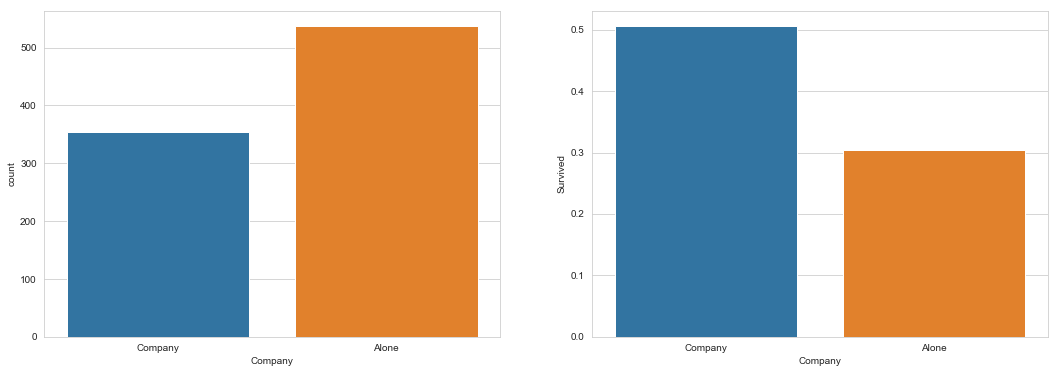

In [27]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(18, 6))
sns.countplot('Company', data=train, ax=axis1)
sns.barplot(x='Company', y='Survived', data=train, ax=axis2, ci=False)
plt.show()

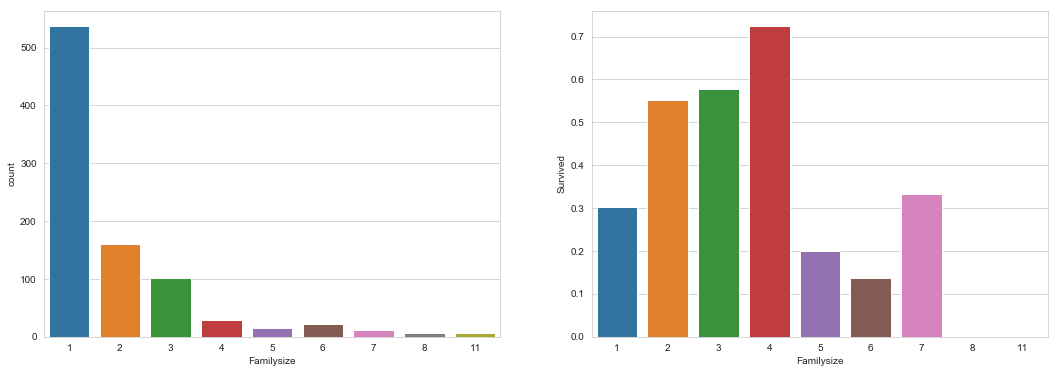

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
sns.countplot('Familysize', data=train, ax=ax1)
sns.barplot(x='Familysize', y='Survived', data=train, ax=ax2, ci=False)
plt.show()

Up to this point, we have seen that survival rates are favorable for passenger in company. This effect could be due to two reasons: first, families helped each other during the tragedy or, second, kids drive up survival rates for families.

There are two possible solutions:
- Compare passengers without company only to families with two without minors. Caveat: loners could be different in many aspects to couples.
- Make a placebo test for couples! If passengers with family size equal to two are radomly matched, characteristics are hold constant, but their bond is not.

The construction of families could be done in two ways. The first approach establishes family groups by surname and size of family. But then, there are ca. 20% families with only one member due to different values of family size. This could be due to divorce, different ways of counting, etc..

Another way would be to group the data by surname and fare, since families buy the same ticket. A quick look in the data reveals, that children probably did not get a discount (e.g. the Carter Family) and families did not split among different passenger classes.

The second solution is chosen but it is not flawless. Look, for example, at the example given below. Since variables like ``SibSp`` can differ for partners, family sizes are also different.

In [29]:
train.groupby(['Surname', 'Fare']).get_group(('Frauenthal', 133.6500))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,missing_age,Deck,Title,Surname,Minor,Familysize,Company
334,335,1,1,"Frauenthal, Mrs. Henry William (Clara Heinshei...",Female,35.226733,1,0,PC 17611,133.65,NaN,Southampton,True,Missing,Married_Woman,Frauenthal,Minor,2,Company
660,661,1,1,"Frauenthal, Dr. Henry William",Male,50.000000,2,0,PC 17611,133.65,NaN,Southampton,False,Missing,Middle_Class,Frauenthal,Minor,3,Company


In [30]:
# Construct families by grouping surname and fare
i = 1
for sur, fare in train.groupby(['Surname', 'Fare']).groups:
    if train.groupby(
        ['Surname', 'Fare']).get_group((sur, fare)).shape[0] == 1:
        pass
    else:
        train.loc[
            (train.Surname == sur) & (train.Fare == fare), 'Familynum'] = i
        i += 1

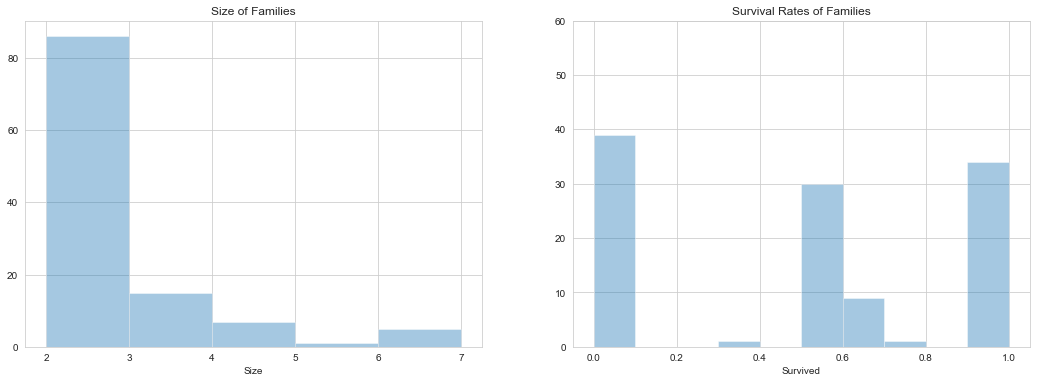

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
familynum_size = train.groupby('Familynum').size()
sns.distplot(familynum_size, kde=False, ax=ax1, bins=np.arange(2, 7.5, 1),
             axlabel='Size')
ax1.set_title('Size of Families')
familynum_perc = train.groupby('Familynum')['Survived'].mean()
sns.distplot(familynum_perc, kde=False, ax=ax2,
             bins=np.arange(0, 1.05, 0.1),)
ax2.set_yticks(np.arange(0, 61, 10))
ax2.set_title('Survival Rates of Families')
plt.show()

The graphic above shows that the size of the constructed families and the frequency of average survival rates for families. Since only complete families have been selected and bigger families have a higher probability of being split among test and train dataset, the distribution of complete families is probably right-skewed (positive skew). To correct for this bias, we will only consider families with two members.

#### First: compare loners with couples

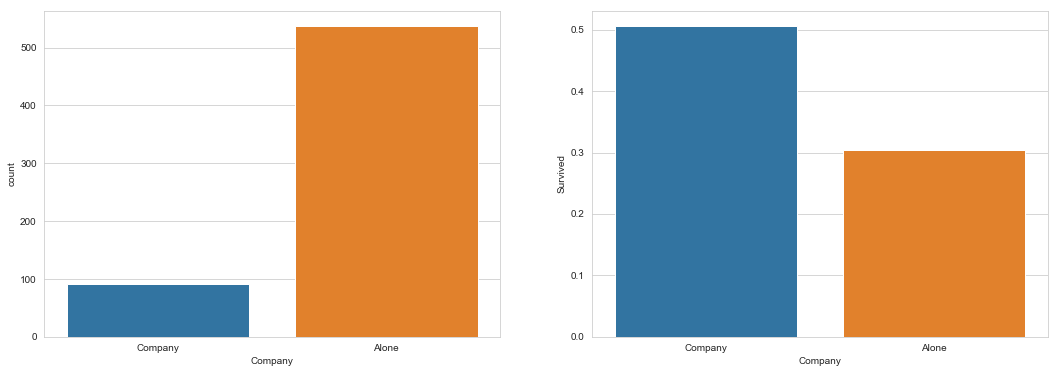

In [32]:
sample = train[(train.Company == 'Alone') | ((train.Familynum.notnull()) &
                                             (train.Familysize == 2))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.countplot('Company', data=sample, ax=ax1, order=['Company', 'Alone'])
sns.barplot(x='Company', y='Survived', data=train, ax=ax2, ci=False)
plt.show()

#### Second: placebo test for couples

The approach for the placebo test is to match all passengers who traveled in couples randomly with another. The idea is that if there is a special bond between couples which increases or decreases survival rates, then randomizing will change the distribution to a binomial distribution.

What is needed? First, the actual distribution of survival outcomes for couples. Second, a distribution of survival outcomes for randomly matched couples. Third, a binomial distribution with a probability equal to the expected individual survival rate.

Since the second and third step rely on randomness, the distributions are bootstrapped to match the expected ones rather than a special case of randomness.

In [33]:
def bootstrap(df):
    bs = pd.DataFrame(columns=[0, 0.5, 1])
    struc = df.Familynum.values
    for i in range(1000):
        df['rand'] = np.random.permutation(struc)
        bs.loc[i] = df.groupby('rand')[
            'Survived'].mean().value_counts().sort_index()
    return bs


def bootstrap_binom():
    bs = pd.DataFrame(columns=[0, 0.5, 1])
    for i in range(1000):
        bs.loc[i] = pd.Series(np.random.binomial(
            1, 0.571, (42, 2)).mean(1)).value_counts().sort_index()
    return bs

In [34]:
sample = train[(train.Familynum.notnull()) & (train.Familysize == 2)].copy()

# This correction is explained in #5
for iden in sample.Familynum.unique():
    if sample[sample.Familynum == iden].shape[0] == 2:
        pass
    else:
        sample = sample[sample.Familynum != iden]

bs = bootstrap(sample)
bs_binom = bootstrap_binom()

We need to other factors, the sample size and the individual survival rate:

In [35]:
print('Individual survival rate: {:.3f}'.format(sample.Survived.mean()))
print('Sample size: {:.0f}'.format(sample.shape[0]))

Individual survival rate: 0.571
Sample size: 84


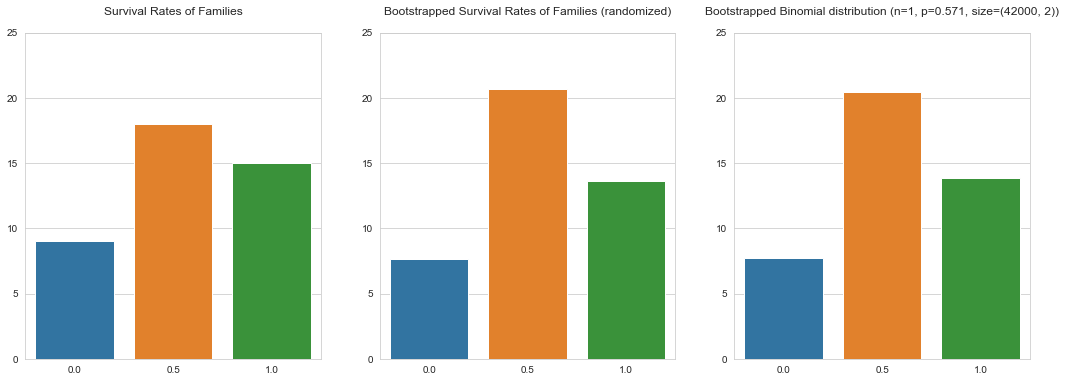

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

familynum_perc = sample.groupby('Familynum')[
    'Survived'].mean().value_counts().sort_index().to_frame().T
sns.barplot(data=familynum_perc, ax=ax1)
ax1.set_yticks(np.arange(0, 26, 5))
ax1.set_title('Survival Rates of Families\n')

sns.barplot(data=bs, ax=ax2, ci=False)
ax2.set_yticks(np.arange(0, 26, 5))
ax2.set_title('Bootstrapped Survival Rates of Families (randomized)\n')

sns.barplot(data=bs_binom, ax=ax3, ci=False)
ax3.set_yticks(np.arange(0, 26, 5))
ax3.set_title(
    'Bootstrapped Binomial distribution (n=1, p=0.571, size=(42000, 2))\n')
plt.show()

I'm not very sure what to make out these graphs. Certainly, the last two graphs look almost identical which would strengthen my belief, that there is some kind of structure in survival rates for families. But still, I have a lot of doubts concerning the methodology and the credibility of the results.

### Predicting Survival

Finally, here is the section about predicting survival rates.

In [37]:
X_train = pd.get_dummies(train[[
    'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck', 'Familysize',
    'Company', 'Title']].copy())
Y_train = train['Survived'].copy()
X_test = pd.get_dummies(test[[
    'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Deck', 'Familysize',
    'Company', 'Title']].copy())

# Hotfix for missing columns
X_test['Deck_T'] = 0
X_test['Title_Nobility'] = 0

In [38]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify classifier
clf = RandomForestClassifier(n_estimators=1000,
                             min_samples_leaf=1,
                             max_depth=None,
                             n_jobs=-1)

# specify parameters and distributions to sample from
param_dist = {
#               "max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(1, 11),
#               "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=-1,
                                   cv=None, error_score=0)

start = time()
random_search.fit(X_train, Y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 44.72 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.822 (std: 0.010)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_features': 7, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.819 (std: 0.012)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 8, 'min_samples_split': 8}

Model with rank: 3
Mean validation score: 0.818 (std: 0.012)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': 3, 'min_samples_split': 10}



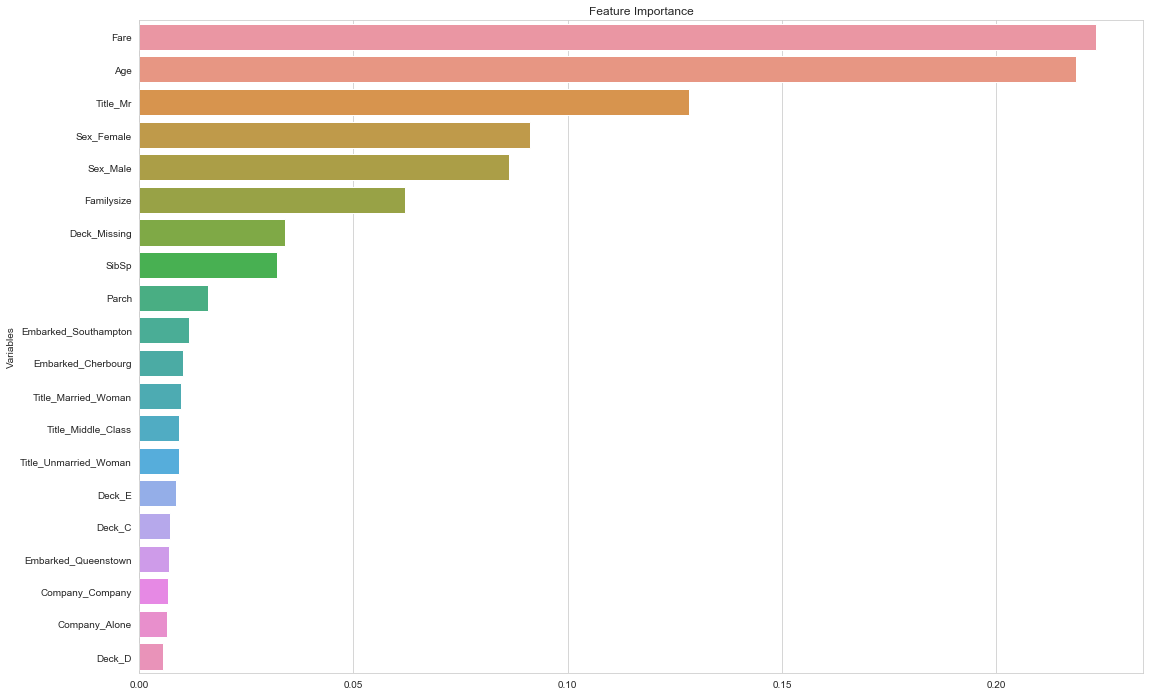

In [39]:
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_features=0.5)
feat_imp = clf.fit(X_train, Y_train).feature_importances_

sur_feat_imp = pd.DataFrame(
    {'Variables': X_train.keys().values, 'Feature Importance': feat_imp}
).sort_values('Feature Importance', ascending=False)

fig, ax = plt.subplots(figsize=(18, 12))
sns.barplot(y='Variables', x='Feature Importance', data=sur_feat_imp[:20],
            ax=ax, orient='h')
ax.set_title('Feature Importance')
ax.set_xlabel('')
plt.show()

In [40]:
results = clf.predict(X_test)
submission = pd.concat(
    [test['PassengerId'], pd.Series(results, name='Survived')])
submission.to_csv(Path('data', 'results.csv'), index=False)